# Import library

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy import stats

from datetime import datetime

from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

# Read dataset

In [2]:
df = pd.read_csv('marketing_campaign_data.csv', index_col = [0])

In [3]:
df.shape

(2240, 29)

In [4]:
df.sample(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoke,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
1796,7002,1955,S1,Lajang,62535000.0,0,1,03-10-2013,13,163000,...,3,0,0,0,0,0,0,3,11,0
2038,6568,1984,S1,Menikah,38680000.0,1,0,28-03-2013,97,11000,...,7,0,0,0,0,0,0,3,11,0
2209,6168,1963,S1,Cerai,45146000.0,1,1,15-07-2013,28,33000,...,4,0,0,0,0,0,0,3,11,0
1841,6906,1953,S2,Janda,84953000.0,0,0,03-06-2013,73,167000,...,2,0,1,1,1,0,0,3,11,1
224,7079,1962,S1,Cerai,63887000.0,0,1,08-09-2012,38,897000,...,6,0,0,0,0,0,0,3,11,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntCoke              2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [6]:
count_nd = pd.DataFrame(df.isnull().sum(), columns=['Total Null Data']).reset_index()
count_nd[count_nd['Total Null Data'] != 0]

,index,Total Null Data
4,Income,24


In [7]:
df['Income'] = df['Income'].fillna(df['Income'].median())

In [8]:
df.duplicated().sum()

0

In [9]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

# Feature Engineering

## Age of customer

In [10]:
time = datetime.now().year
time

2023

In [11]:
df['age'] = time - df['Year_Birth']

## Total Children

In [12]:
df['total_children'] = df['Kidhome'] + df['Teenhome']

## Group of Age

In [13]:
goa = []

for i in df['age']:
    if i < 35 :
        grup = 'Young Adult'
    elif i < 65 :
        grup = 'Adult'
    else:
        grup = 'Senior Adult'
    goa.append(grup)

df['grup_age'] = goa

## Total of accepted campaign

In [14]:
acc_cmp = [col for col in df.columns if 'AcceptedCmp' in col]

df['Total_accepted_campaign'] = df[acc_cmp].sum(axis=1)

## Total of Purchases

In [15]:
df['Total_Purchases'] = ( df['NumDealsPurchases'] + df['NumWebPurchases'] 
                        + df['NumCatalogPurchases'] + df['NumStorePurchases'])

## Total amount

In [16]:
df['Total_amount'] = df[['MntCoke','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds']].sum(axis=1)

## Conversion Rate

In [17]:
df['conversion_rate'] = np.round(df['Total_Purchases'] / df['NumWebVisitsMonth'], 2)

## Total of days/years joined

In [18]:
df['Total_Days_Joined'] = (datetime.now() - df['Dt_Customer'])
df['Total_Days_Joined'] = df['Total_Days_Joined'].dt.days

In [19]:
df['Year_Joined'] = np.round(df['Total_Days_Joined'] / 365 , 0)
df['Year_Joined'] = df['Year_Joined'].astype(int)

## Drop Unnecessary Data

In [20]:
num_cmp = [col for col in df.columns if 'Num' in col]
mnt_cmp = [col for col in df.columns if 'Mnt' in col]

col_to_drop = num_cmp + mnt_cmp + acc_cmp

df.drop(columns = col_to_drop, inplace=True)
df.drop(columns = ['Year_Birth', 'ID', 'Kidhome', 'Teenhome'], inplace=True)

# Looking for a relationship between conversion rate and the types of users who are potentially more likely to respond to a campaign

In [21]:
def get_nonself_correlation(df,self_name):
    temp = df.select_dtypes(exclude=object).corr().abs()
    temp = temp.loc[temp.index!=self_name,temp.columns==self_name]
    temp = temp.unstack().reset_index()
    temp.columns = ['corr_matrix', 'dfbase', 'correlation'] 
    return temp

In [22]:
a = get_nonself_correlation(df, 'Total_accepted_campaign').sort_values(by='correlation', ascending = False).reset_index()
a

,index,corr_matrix,dfbase,correlation
0,9,Total_accepted_campaign,Total_amount,0.459554
1,5,Total_accepted_campaign,Response,0.426035
2,0,Total_accepted_campaign,Income,0.307122
3,8,Total_accepted_campaign,Total_Purchases,0.257273
4,7,Total_accepted_campaign,total_children,0.244282
5,10,Total_accepted_campaign,conversion_rate,0.235339
6,12,Total_accepted_campaign,Year_Joined,0.023521
7,2,Total_accepted_campaign,Complain,0.022220
8,11,Total_accepted_campaign,Total_Days_Joined,0.017704
9,1,Total_accepted_campaign,Recency,0.012570


According to the correlation between the total_accepted_campaign column with another numeric column, there are have 5 top columns called total_amount, response, income, total purchases, and total children

In [23]:
cat = []
num = []
dat = []

numeric = ['int64', 'int32', 'float64']

for i in df.columns:
    data_type = str(df[i].dtype)
    if data_type == 'object' :
        cat.append(i)
    elif data_type in numeric :
        num.append(i)
    else:
        dat.append(i)

In [24]:
for col in cat:
    # create the contingency table
    contingency_table = pd.crosstab(df['Total_accepted_campaign'], df[col])

    # calculate the chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-squared test for {col}:")
    print("Chi-squared test statistic: ", chi2)
    print("p-value: ", p)
    print("\n")

Chi-squared test for Education:
Chi-squared test statistic:  13.652661876664261
p-value:  0.6245722039336392


Chi-squared test for Marital_Status:
Chi-squared test statistic:  14.449720719561753
p-value:  0.8069820454432217


Chi-squared test for grup_age:
Chi-squared test statistic:  16.430737547135532
p-value:  0.036613853379265




we can see that grup_age column have the lowest value of p-value, so it's mean that there is a significant assocation between grup_age and total_accepted_campaign

In [25]:
from scipy.stats import kendalltau

# calculate the Kendall's tau
for col in cat:
    corr, p = kendalltau(df['Total_accepted_campaign'], df[col])
    print(f"Kendall's tau {col}: ", corr)
    print("p-value: ", p)

Kendall's tau Education:  0.016141073374069795
p-value:  0.39932511808086635
Kendall's tau Marital_Status:  0.009742408571626327
p-value:  0.6064925560787362
Kendall's tau grup_age:  0.05325704862050624
p-value:  0.008690000767586078


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:110: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "


In [26]:
from scipy.stats import spearmanr

# calculate the Spearman's rank correlation
for col in cat:
    corr, p = spearmanr(df['Total_accepted_campaign'], df[col])
    print(f"Spearman's rank correlation {col}: ", corr)
    print("p-value: ", p)

Spearman's rank correlation Education:  0.01782552652320855
p-value:  0.39908641509598164
Spearman's rank correlation Marital_Status:  0.01086844474062379
p-value:  0.6071703659012476
Spearman's rank correlation grup_age:  0.055390151249012635
p-value:  0.008739229563143776


Using spearman and kendalltau to know correlation between total_accepted_campaign with categories value, we got grup_age have a higher correlation than another column.

## Analysis

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2240 entries, 0 to 2239
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Education                2240 non-null   object        
 1   Marital_Status           2240 non-null   object        
 2   Income                   2240 non-null   float64       
 3   Dt_Customer              2240 non-null   datetime64[ns]
 4   Recency                  2240 non-null   int64         
 5   Complain                 2240 non-null   int64         
 6   Z_CostContact            2240 non-null   int64         
 7   Z_Revenue                2240 non-null   int64         
 8   Response                 2240 non-null   int64         
 9   age                      2240 non-null   int64         
 10  total_children           2240 non-null   int64         
 11  grup_age                 2240 non-null   object        
 12  Total_accepted_campaign  2240 non-

In [28]:
num_column = ['Total_amount', 'Response', 'Income', 'Total_Purchases','total_children']
cat_column = ['grup_age']

column = num_column + cat_column

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anacond

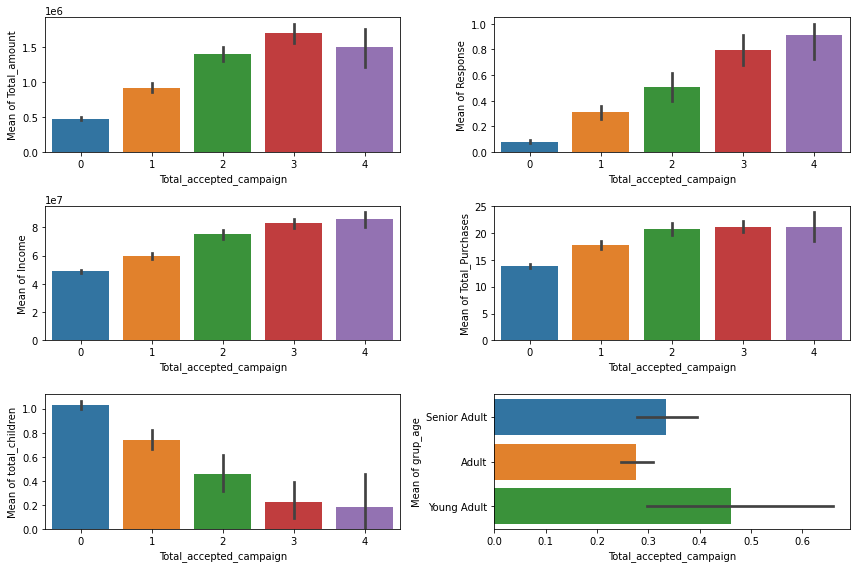

In [29]:
plt.figure(figsize=(12,8))

for i, col in enumerate (df[column], 1):
    plt.subplot(3,2,i)
    sns.barplot(df['Total_accepted_campaign'], df[col])
    plt.ylabel(f'Mean of {col}')
    plt.tight_layout()

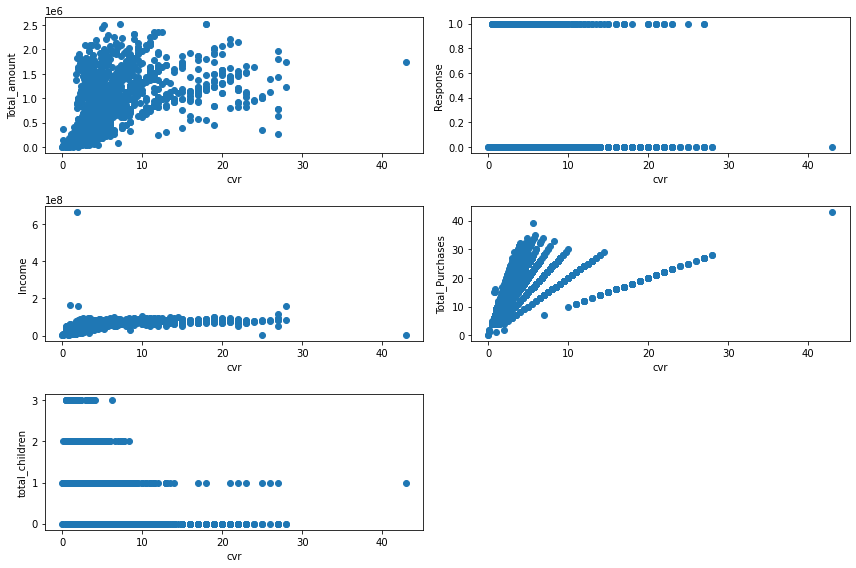

In [30]:
plt.figure(figsize=(12,8))

for i, col in enumerate (df[num_column], 1):
    plt.subplot(3,2,i)
    plt.scatter(df['conversion_rate'], df[col])
    plt.ylabel(f'{col}')
    plt.xlabel('cvr')
    plt.tight_layout()

# Data Preprocessing

## Change the value in the column

In [31]:
not_marry = ['Lajang', 'Bertunangan']
marry = ['Menikah', 'Cerai', 'Janda', 'Duda']

marital_Status = []
for i in df['Marital_Status']:
    if i in not_marry:
        status = 'Never been married'
    else:
        status = 'Ever been married'
    marital_Status.append(status)
    
df['Marital_Status'] = marital_Status

## Look for a numeric data type that has a unique value > 2

For numeric column with unique value more than 2, we will do data transformation

In [32]:
num = df[num]

df_num = pd.DataFrame(num.nunique(), columns = ['Total_unique']).reset_index()
df_num = df_num.rename(columns = {'index' : 'Name_of_column'})

num_a = []
num_b = []
for i,y in enumerate(df_num.Name_of_column):
    if df_num['Total_unique'][i] > 2:
        num_a.append(y)
    else:
        num_b.append(y)

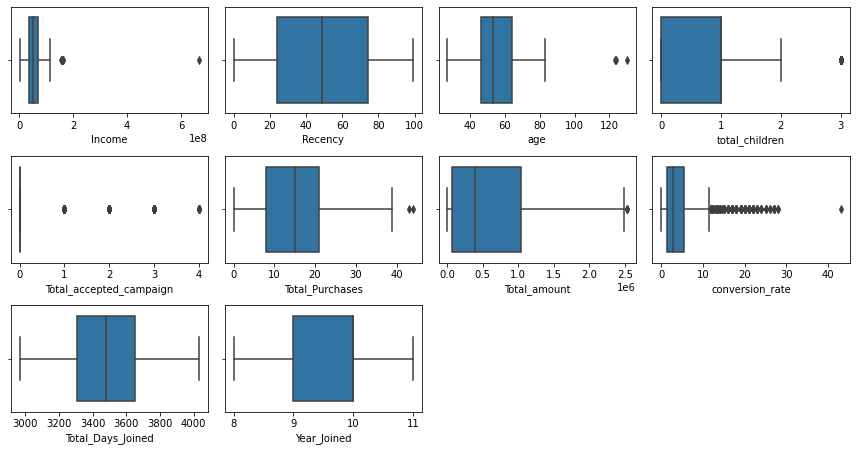

In [33]:
plt.figure(figsize=(12,8))

for i, column in enumerate (df[num_a].columns, 1):
    plt.subplot(4,4,i)
    sns.boxplot(data=df[num_a], x=df[column])
    plt.tight_layout()

we will delete outlier at Income and age column with Z-Score

In [34]:
print(f'Total rows before delete outlier: {len(df)}')

filtered_entries = np.array([True] * len(df))
nums = ['Income', 'age']

for col in nums:
    zscore = abs(stats.zscore(df[col])) # hitung absolute z-scorenya
    filtered_entries = (zscore < 3) & filtered_entries # keep yang kurang dari 3 absolute z-scorenya
    
df = df[filtered_entries] # filter, cuma ambil yang z-scorenya dibawah 3
df[num_a] = df[num_a].replace([np.inf, -np.inf], 0)

print(f'Total rows after delete outlier: {len(df)}')

Total rows before delete outlier: 2240
Total rows after delete outlier: 2229


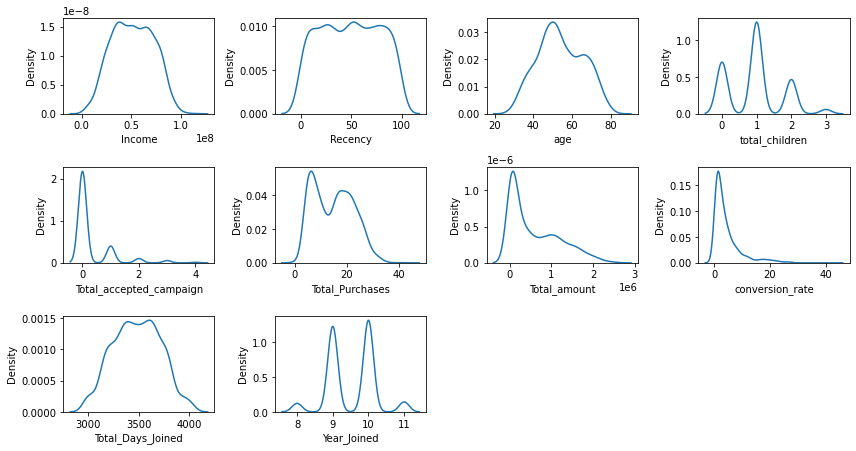

In [35]:
plt.figure(figsize=(12,8))

for i, column in enumerate (df[num_a].columns, 1):
    plt.subplot(4,4,i)
    sns.kdeplot(data=df[num_a], x=df[column])
    plt.tight_layout()

In [36]:
df_2 = df.copy()

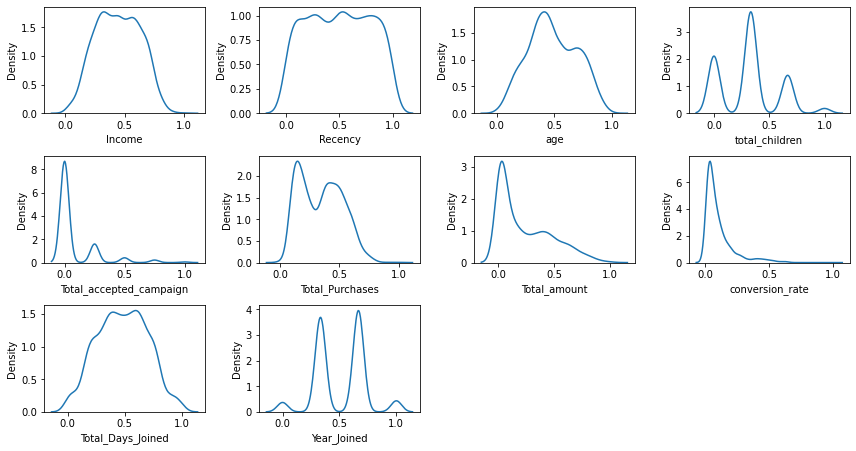

In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features = df[num_a]

df[num_a] = scaler.fit_transform(features.values)

plt.figure(figsize=(12,8))
for i, column in enumerate (df[num_a].columns, 1):
    plt.subplot(4,4,i)
    sns.kdeplot(data=df, x=df[column])
    plt.tight_layout()

## Label Encoding

Because all the categories column have Ordinal data, so we can use label encoding.

In [38]:
df[num_a].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2229 entries, 0 to 2239
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Income                   2229 non-null   float64
 1   Recency                  2229 non-null   float64
 2   age                      2229 non-null   float64
 3   total_children           2229 non-null   float64
 4   Total_accepted_campaign  2229 non-null   float64
 5   Total_Purchases          2229 non-null   float64
 6   Total_amount             2229 non-null   float64
 7   conversion_rate          2229 non-null   float64
 8   Total_Days_Joined        2229 non-null   float64
 9   Year_Joined              2229 non-null   float64
dtypes: float64(10)
memory usage: 256.1 KB


In [39]:
# Label Encoding
mapping_education = {
    'SMA' : 0,
    'D3'  : 1,
    'S1'  : 2,
    'S2'  : 3,
    'S3'  : 4
} 

mapping_marital = {
    'Never been married' : 0,
    'Ever been married' : 1
}

mapping_grup_age = {
    'Young Adult' : 0,
    'Adult'  : 1,
    'Senior Adult' : 2
}

df['Education'] = df['Education'].map(mapping_education)
df['Marital_Status'] = df['Marital_Status'].map(mapping_marital)
df['grup_age'] = df['grup_age'].map(mapping_grup_age)


# Modeling

At this case,I will do unsupervised learning, namely clustering, first thing what I will do is feature selection.

## Feature Selection

For segmenting customer, there is a method called RFM Analysis, 
for you want to know deeply about RFM can read this reference : https://www.barilliance.com/rfm-analysis/#:~:text=RFM%20analysis%20is%20a%20data,much%20they've%20spent%20overall.

Recency      : Date of Last of Purchases : Recency

Frequency    : Total Number of Orders    : Total_Purchases

Monetization : Total order value         : Total_amount

Loyalty      : Total campaign accepted   : Total_accepted_campaign

In [40]:
df_mod = df[['Recency', 'Total_Purchases', 'Total_amount', 'Total_accepted_campaign']]

In [41]:
mod_col = df_mod.columns

## K-Means

### Elbow Score

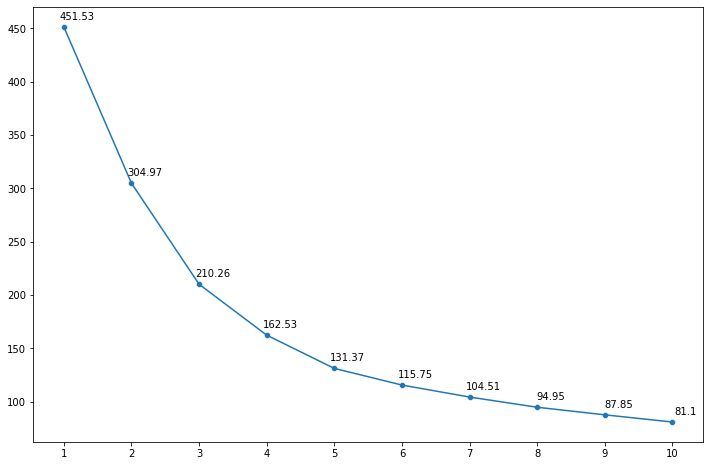

In [42]:
inertia=[]

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_mod)
    inertia.append(np.round(kmeans.inertia_ ,2))

x = range(1,11)
    
plt.figure(figsize=(12,8))
sns.lineplot(x=x, y=inertia)    
sns.scatterplot(x=x, y=inertia)

for i, label in enumerate(inertia):
    plt.text(x[i] + 0.2, inertia[i] + 5, label, ha='center', va='bottom')
    
plt.xticks(range(1,11 ,1))
plt.show()

For picture above, we can see when n_cluster = 4, the inertia score did'nt change significantly, so we will use n_cluster = 4

### Silhouette score

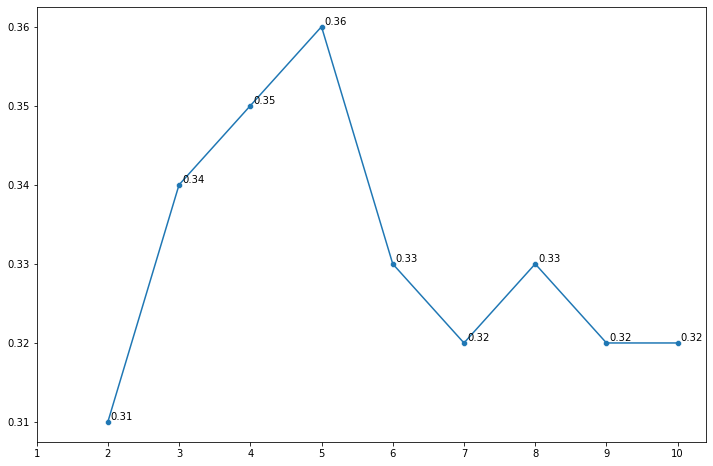

In [43]:
arr_silhouette_score = []

for i in range(2,11):
    kmeans = KMeans(n_clusters=i).fit(df_mod)
    preds = kmeans.predict(df_mod)
    score_euclidean = silhouette_score(df_mod, preds, metric='euclidean')
    arr_silhouette_score.append(np.round(score_euclidean ,2))
    
x = range(2,11)
    
plt.figure(figsize=(12,8))
sns.lineplot(x=x, y=arr_silhouette_score)    
sns.scatterplot(x=x, y=arr_silhouette_score)

for i, label in enumerate(arr_silhouette_score):
    plt.text(x[i] + 0.2, arr_silhouette_score[i], label, ha='center', va='bottom')
    
plt.xticks(range(1,11 ,1))
plt.show()

from picture above, we can see that when n=cluster = 4, it get 0.35 at silhoutte score

## Train Model

In [44]:
model = KMeans(n_clusters=4, random_state=0).fit(df_mod)
df_mod['Cluster'] = model.labels_
df['Cluster'] = model.labels_

C:\Users\RAFFEL~1\AppData\Local\Temp/ipykernel_22844/883679810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod['Cluster'] = model.labels_


In [45]:
df

,Education,Marital_Status,Income,Dt_Customer,Recency,Complain,Z_CostContact,Z_Revenue,Response,age,total_children,grup_age,Total_accepted_campaign,Total_Purchases,Total_amount,conversion_rate,Total_Days_Joined,Year_Joined,Cluster
0,2,0,0.503625,2012-04-09,0.585859,0,3,11,1,0.696429,0.000000,2,0.00,0.581395,0.639683,0.083023,0.913452,1.000000,2
1,2,0,0.398325,2014-08-03,0.383838,0,3,11,0,0.750000,0.666667,2,0.00,0.139535,0.008730,0.027907,0.117592,0.000000,3
2,2,0,0.623933,2013-08-21,0.262626,0,3,11,0,0.553571,0.000000,1,0.00,0.488372,0.305952,0.122093,0.444026,0.333333,0
3,2,0,0.222456,2014-10-02,0.262626,0,3,11,0,0.214286,0.333333,1,0.00,0.186047,0.019048,0.030930,0.061148,0.000000,3
4,4,1,0.505009,2014-01-19,0.949495,0,3,11,0,0.267857,0.333333,1,0.00,0.441860,0.165476,0.088372,0.301976,0.333333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,2,1,0.531169,2013-06-13,0.464646,0,3,11,0,0.517857,0.333333,1,0.00,0.418605,0.530159,0.083721,0.508937,0.666667,2
2236,4,0,0.556087,2014-10-06,0.565657,0,3,11,0,0.892857,1.000000,2,0.25,0.511628,0.174206,0.073023,0.057385,0.000000,2
2237,2,1,0.493295,2014-01-25,0.919192,0,3,11,0,0.267857,0.000000,1,0.25,0.441860,0.490476,0.073721,0.296331,0.333333,2
2238,3,0,0.602791,2014-01-24,0.080808,0,3,11,0,0.714286,0.333333,2,0.00,0.534884,0.332540,0.178372,0.297272,0.333333,0


### PCA

In [46]:
df_pca = df_mod.drop(columns = 'Cluster')

In [47]:
df_pca

,Recency,Total_Purchases,Total_amount,Total_accepted_campaign
0,0.585859,0.581395,0.639683,0.00
1,0.383838,0.139535,0.008730,0.00
2,0.262626,0.488372,0.305952,0.00
3,0.262626,0.186047,0.019048,0.00
4,0.949495,0.441860,0.165476,0.00
...,...,...,...,...
2235,0.464646,0.418605,0.530159,0.00
2236,0.565657,0.511628,0.174206,0.25
2237,0.919192,0.441860,0.490476,0.25
2238,0.080808,0.534884,0.332540,0.00


In [48]:
pca = PCA(n_components=2)
pca.fit(df_pca)
x_pca = pca.transform(df_pca)

In [49]:
pdf = pd.DataFrame(x_pca, columns= ['pc1', 'pc2'])

In [50]:
pdf['Cluster'] = model.labels_
pdf

,pc1,pc2,Cluster
0,0.355412,0.231492,2
1,-0.298286,-0.145800,3
2,-0.095331,0.234761,0
3,-0.362883,-0.038344,3
4,0.302549,-0.339840,1
...,...,...,...
2224,0.149428,0.194126,2
2225,0.112082,0.020597,2
2226,0.516744,-0.073874,2
2227,-0.194344,0.393574,0


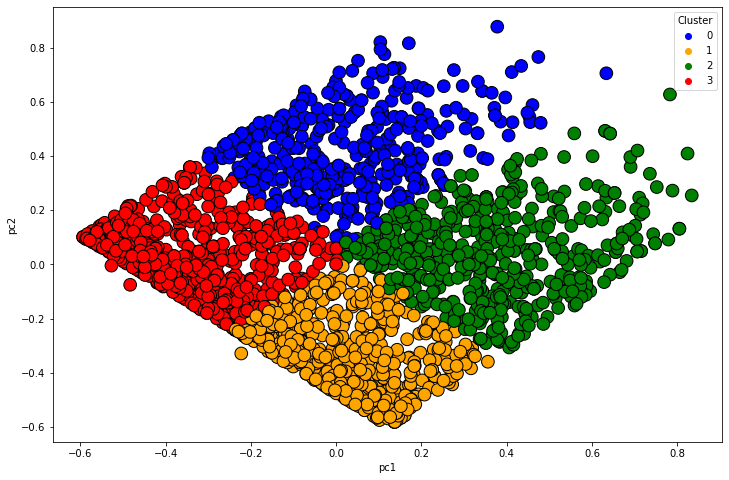

In [51]:
fig,ax = plt.subplots(figsize=(12,8))

sns.scatterplot(
    x="pc1", y="pc2",
    hue="Cluster",
    edgecolor='black',
    #linestyle='--',
    data=pdf,
    palette=['blue','orange','green','red'],
    s=160,
    ax=ax
);

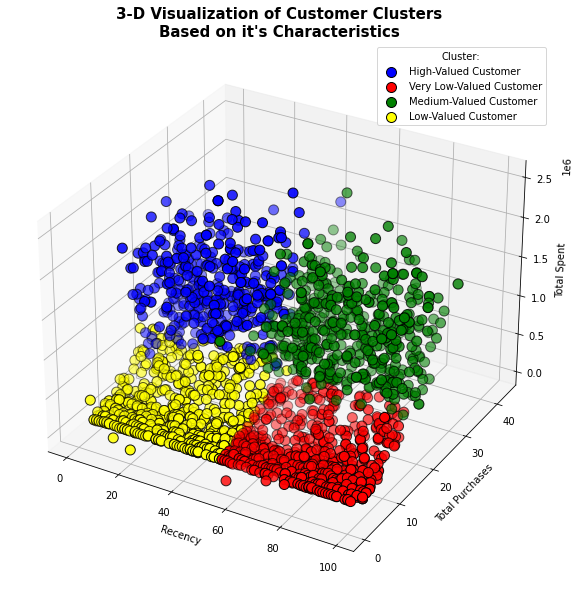

In [52]:
df_2['Cluster'] = model.labels_

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
plt.title("3-D Visualization of Customer Clusters\nBased on it's Characteristics", fontsize=15, weight='bold')
ax.scatter(df_2['Recency'][df_2.Cluster == 0], df_2['Total_Purchases'][df_2.Cluster == 0], df_2['Total_amount'][df_2.Cluster == 0], c='blue', s=100, edgecolor='black', label='High-Valued Customer')
ax.scatter(df_2['Recency'][df_2.Cluster == 1], df_2['Total_Purchases'][df_2.Cluster == 1], df_2['Total_amount'][df_2.Cluster == 1], c='red', s=100, edgecolor='black', label='Very Low-Valued Customer')
ax.scatter(df_2['Recency'][df_2.Cluster == 2], df_2['Total_Purchases'][df_2.Cluster == 2], df_2['Total_amount'][df_2.Cluster == 2], c='green', s=100, edgecolor='black',  label='Medium-Valued Customer')
ax.scatter(df_2['Recency'][df_2.Cluster == 3], df_2['Total_Purchases'][df_2.Cluster == 3], df_2['Total_amount'][df_2.Cluster == 3], c='yellow', s=100, edgecolor='black', label='Low-Valued Customer')
plt.xlabel('Recency')
plt.ylabel('Total Purchases')
ax.set_zlabel('Total Spent')
plt.legend(title='Cluster:')
plt.show()

# Insight from Model

In [53]:
cluster = []

for i in df_2['Cluster']:
    if i == 0:
        grup = 'High Value Customer'
    elif i == 1:
        grup = 'Very Low Value Customer'
    elif i == 2:
        grup = 'Medium Value Customer'
    else :
        grup = 'Low Value Customer'
    cluster.append(grup)
    
df_2['Cluster'] = cluster

In [54]:
mod_col = mod_col.insert(1, 'Cluster')
display(df_2[mod_col].groupby('Cluster').agg(['mean','median', 'max', 'min']))

Recency                Total_Purchases             \
                              mean median max min            mean median max   
Cluster                                                                        
High Value Customer      21.608273   22.0  47   0       22.204380   22.0  43   
Low Value Customer       23.582689   24.0  49   0        9.814529    9.0  27   
Medium Value Customer    71.895717   72.0  99  45       21.689013   22.0  39   
Very Low Value Customer  73.676656   74.5  99  49        9.495268    8.0  21   

                             Total_amount                              \
                        min          mean     median      max     min   
Cluster                                                                 
High Value Customer      11  1.232810e+06  1175000.0  2525000  372000   
Low Value Customer        0  1.722875e+05    85000.0   850000    6000   
Medium Value Customer     1  1.183737e+06  1127000.0  2524000  416000   
Very Low Value Customer   0  1.513076e+05    81000.0   801000    5000   

                        Total_accepted_campaign                 
                                           mean median max min  
Cluster                                                         
High Value Customer                    0.669100    0.0   4   0  
Low Value Customer                     0.092736    0.0   2   0  
Medium Value Customer                  0.528864    0.0   4   0  
Very Low Value Customer                0.074132    0.0   1   0

In [62]:
df_ac = df_2.groupby(['Cluster'])['age'].count().reset_index()
df_ac.rename(columns = {'age' : 'Total Customer'}, inplace=True)
df_ac['Percentage'] = np.round(df_ac['Total Customer'] / df_ac['Total Customer'].sum() * 100, 2)
df_ac

,Cluster,Total Customer,Percentage
0,High Value Customer,411,18.44
1,Low Value Customer,647,29.03
2,Medium Value Customer,537,24.09
3,Very Low Value Customer,634,28.44


In [64]:
df_ac2 = df_2.groupby(['Cluster', 'Total_accepted_campaign'])['age'].count().reset_index()
df_ac2.rename(columns = {'age' : 'Total Customer'}, inplace=True)
df_ac2

,Cluster,Total_accepted_campaign,Total Customer
0,High Value Customer,0,236
1,High Value Customer,1,107
2,High Value Customer,2,42
3,High Value Customer,3,20
4,High Value Customer,4,6
5,Low Value Customer,0,590
6,Low Value Customer,1,54
7,Low Value Customer,2,3
8,Medium Value Customer,0,354
9,Medium Value Customer,1,116


## Potential Impact (Quantitative)

In [70]:
high_valued   = df_2[df_2['Cluster'] == 'High Value Customer']['Total_amount'].sum()
medium_valued = df_2[df_2['Cluster'] == 'Medium Value Customer']['Total_amount'].sum()
low_valued    = df_2[df_2['Cluster'] == 'Low Value Customer']['Total_amount'].sum()
very_low_valued = df_2[df_2['Cluster'] == 'Very Low Value Customer']['Total_amount'].sum()
total = high_valued + medium_valued + low_valued + very_low_valued

print(f'Total Spent of High Value Customer : Rp. {high_valued}')
print(f'Total Spent of Medium Value Customer : Rp. {medium_valued}')
print(f'Total Spent of Low Value Customer : Rp. {low_valued}')
print(f'Total Spent of Very Low Value Customer : Rp. {very_low_valued}')
print(f'Total : Rp. {total}')

Total Spent of High Value Customer : Rp. 506685000
Total Spent of Medium Value Customer : Rp. 635667000
Total Spent of Low Value Customer : Rp. 111470000
Total Spent of Very Low Value Customer : Rp. 95929000
Total : Rp. 1349751000
